# Transcriptomic subtypes relationship to cell proportions in Schildkraut HGSOC

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns, matplotlib.pyplot as plt
import os 
import itertools
import sys 

sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../')

import src.hp as hp

np.random.seed(88)

## Load survival metadata

In [ ]:
base_path = os.path.dirname(os.getcwd())
meta_path = os.path.join(base_path, "input_data/metadata.xlsx") 

remove_treatment = False
remove_pts_with_unknowns= True

map_stage = True
remove_unknown_stage = True

In [4]:
subB = os.path.join(base_path, "output_data/bulk_data_clustering_and_subtypes/SchildkrautB_clustering_labels.csv")
subW =  os.path.join(base_path, "output_data/bulk_data_clustering_and_subtypes/SchildkrautW_clustering_labels.csv")

subtype_order = ["Immunoreactive", "Differentiated", "Mesenchymal", "Proliferative"]

In [5]:
fractions      = ["Adipocytes", "Immune", "Stromal", "Epithelial"]

## Load InstaPrism cell-fraction tables (processed) and metadata

Proportions

In [6]:
props = pd.read_csv(os.path.join(base_path, "input_data/proportions_sch.csv"), index_col=0)
props

,SampleID,Plasma cells,B cells,Endothelial cells,T cells,Monocytes,Fibroblasts,NK cells,Epithelial cells,DC,pDC,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset,suid,ID
0,18341X10,4.919765e-49,0.052767,0.029870,1.833554e-26,1.727071e-60,7.074672e-105,8.375315e-10,0.746341,1.257780e-139,3.590420e-30,2.867046e-78,1.185148e-02,1.538137e-57,0.0,0.159171,SchildkrautB,18341X10,45369
1,18341X12,9.351753e-92,0.027159,0.011666,5.972580e-66,2.258210e-157,8.180384e-107,8.135649e-61,0.848153,3.276474e-210,2.054386e-103,1.247009e-85,2.337775e-128,1.452291e-115,0.0,0.113022,SchildkrautB,18341X12,47261
2,18341X13,6.998799e-32,0.014663,0.041547,1.004614e-23,3.232466e-34,1.225464e-02,9.550579e-19,0.819028,1.104356e-115,3.157063e-69,7.123720e-41,2.994756e-02,1.850941e-63,0.0,0.082561,SchildkrautB,18341X13,47791
3,18341X14,2.410384e-97,0.162711,0.022343,2.056824e-52,5.485488e-33,2.751866e-120,7.904174e-39,0.642545,4.774011e-154,1.326676e-75,2.334007e-77,1.516542e-02,1.488048e-80,0.0,0.157235,SchildkrautB,18341X14,47916
4,18341X15,3.439318e-76,0.050581,0.055021,5.687981e-28,5.314872e-52,8.961526e-02,2.919113e-22,0.649017,7.625379e-122,1.873123e-52,3.487465e-81,1.419715e-02,4.216693e-41,0.0,0.141568,SchildkrautB,18341X15,48002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,20160X95,1.442627e-108,0.136578,0.014420,3.410104e-30,3.267116e-82,7.666630e-23,1.501224e-35,0.710289,6.509988e-151,4.903142e-78,8.571710e-105,3.473745e-03,5.671299e-79,0.0,0.135240,SchildkrautW,20160X95,47786
584,20160X96,1.359916e-92,0.190881,0.017396,5.383974e-33,2.734703e-86,1.156925e-02,1.945285e-24,0.592805,1.063562e-147,5.374615e-82,8.551669e-96,1.270617e-02,4.370517e-04,0.0,0.174205,SchildkrautW,20160X96,47903
585,20160X97,7.862780e-79,0.102850,0.053137,8.610293e-03,1.076987e-46,4.237821e-02,1.467756e-05,0.656171,3.397744e-114,5.089409e-39,1.625064e-79,2.253584e-02,9.865474e-05,0.0,0.114204,SchildkrautW,20160X97,47926
586,20160X98,1.245316e-60,0.127050,0.034344,1.345753e-16,5.846372e-04,2.787547e-02,2.169830e-04,0.673204,4.422809e-95,4.998254e-48,3.881728e-35,5.796692e-04,4.236351e-47,0.0,0.136146,SchildkrautW,20160X98,47937


In [7]:
## The order for the plots:
desired_order = [
    'Age',
    'BMI',
    'No Adj Tx.',
    'Race: Black',
    'Residual: < 1cm',
    'Residual: ≥ 1cm',
    'Residual: Unknown size',
]
if remove_treatment:
    desired_order.remove('No Adj Tx.')
    desired_order.remove('Residual: < 1cm')
    desired_order.remove('Residual: ≥ 1cm')
    desired_order.remove('Residual: Unknown size')
desired_order

['Age',
 'BMI',
 'No Adj Tx.',
 'Race: Black',
 'Residual: < 1cm',
 'Residual: ≥ 1cm',
 'Residual: Unknown size']

### Build the analysis table  (clinical + cell fractions)


In [ ]:
renaming = hp.get_variable_renaming()
tissue_dictionary = hp.get_tissue_dictionary()
# continuous covariates to keep “as is”
cont_cols = ["Age", "BMI"]

Metadata

In [10]:
meta_full = hp.open_and_clean_meta(meta_path=meta_path,
                                    renaming=renaming, 
                                    tissue_dictionary=tissue_dictionary)

In [11]:
#match index in both
meta_full.index = meta_full.ID
props.index = props.ID
props.drop(columns=["ID", "SampleID", "suid"], inplace=True)

## and merge:
df = meta_full.join(props, how="inner")

cell_types = [col for col in df.columns if col not in meta_full.columns and col not in cont_cols]
cell_types.remove("Dataset")

df

,ID,Age,Event,Time_Yrs,Tissue,Stage,Race,BMI,AdjTx,Residual,...,NK cells,Epithelial cells,DC,pDC,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset
ID,,,,,,,,,,,,,,,,,,,,,
40143,40143,63,1,8.739220,NaN,3,1,23.218229,1.0,4.0,...,9.808751e-12,0.610632,1.004328e-110,2.784970e-66,3.408820e-86,2.396804e-02,1.848657e-50,0.0,0.113422,SchildkrautW
41377,41377,54,1,1.180014,NaN,3,1,17.428942,NaN,3.0,...,1.760940e-62,0.702189,1.298550e-208,3.770200e-114,5.097006e-86,1.148229e-151,2.716906e-120,0.0,0.169611,SchildkrautW
41387,41387,55,1,11.983573,NaN,3,2,45.470350,1.0,2.0,...,1.680504e-02,0.725604,1.103526e-97,9.654211e-04,3.169795e-58,6.457394e-02,9.868737e-88,0.0,0.064832,SchildkrautB
41391,41391,60,1,4.993840,NaN,3,1,31.340800,NaN,3.0,...,2.241865e-19,0.660983,3.521124e-102,3.787996e-28,1.975079e-50,1.760802e-02,3.608451e-57,0.0,0.119373,SchildkrautW
41435,41435,59,1,4.057495,NaN,3,1,23.922658,NaN,NaN,...,4.262662e-11,0.739953,8.402589e-122,2.637763e-60,2.022724e-88,5.507985e-03,3.092821e-03,0.0,0.110333,SchildkrautW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310266,310266,40,0,9.702186,Fallopian Tube,3,2,28.349557,NaN,NaN,...,1.374198e-10,0.777904,3.501752e-85,4.856912e-52,2.991107e-53,1.842305e-02,3.506149e-04,0.0,0.097551,SchildkrautB
320012,320012,66,0,11.767760,NaN,3,2,37.677475,1.0,4.0,...,1.048037e-48,0.771372,3.272227e-203,2.444034e-102,2.676690e-115,2.749868e-124,8.635726e-145,0.0,0.135411,SchildkrautB
320025,320025,60,1,6.827869,Other,3,2,38.740537,1.0,3.0,...,6.829921e-59,0.660166,6.138234e-174,1.089373e-96,7.514971e-104,2.901155e-89,6.676818e-64,0.0,0.181209,SchildkrautB


In [12]:
# ─────────────────────────────────────────────────────────────────────────
# Processing clustering too
# ─────────────────────────────────────────────────────────────────────────

subB = os.path.join(base_path, "output_data/bulk_data_clustering_and_subtypes/SchildkrautB_clustering_labels.csv")
subW =  os.path.join(base_path, "output_data/bulk_data_clustering_and_subtypes/SchildkrautW_clustering_labels.csv")
subtypeB = pd.read_csv(subB, index_col=0)
subtypeW = pd.read_csv(subW, index_col=0)
subtypeW["ID"] = subtypeW.index
subtypeB["ID"] = subtypeB.index
subtypeB

,ClusterK2_kmeans,ClusterK3_kmeans,ClusterK4_kmeans,ClusterK2_NMF,ClusterK3_NMF,ClusterK4_NMF,consensusOVsubtype,Dataset,ID
ID,,,,,,,,,
18341X10,2,3,1,1,1,1,DIF_consensus,SchildkrautB,18341X10
18341X12,2,2,4,2,3,3,PRO_consensus,SchildkrautB,18341X12
18341X13,2,3,4,1,2,2,DIF_consensus,SchildkrautB,18341X13
18341X14,2,3,2,2,3,3,IMR_consensus,SchildkrautB,18341X14
18341X15,2,3,1,1,2,2,PRO_consensus,SchildkrautB,18341X15
...,...,...,...,...,...,...,...,...,...
19291X94,2,3,1,1,1,1,MES_consensus,SchildkrautB,19291X94
19291X95,2,3,4,1,2,2,DIF_consensus,SchildkrautB,19291X95
19291X97,2,3,2,1,1,1,IMR_consensus,SchildkrautB,19291X97


In [13]:
map_black  = pd.read_csv(os.path.join(base_path,"input_data/sample_metadata.tsv"),          sep="\t")
map_white  = pd.read_csv(os.path.join(base_path,"input_data/sample_metadata_whites.tsv"),   sep="\t")

mapping = (pd.concat([map_black, map_white], ignore_index=True)
             .loc[:, ["suid", "ID"]]          # keep only key columns
             .rename(columns={"ID": "SampleID"}))
mapping["suid"] = (mapping["suid"]
                   .astype(str)
                   .str.extract(r"(\d+)", expand=False)   # keep digits
                   .astype(int))

mapping_dict = dict(zip(mapping['SampleID'], mapping['suid']))
mapping_dict

{'19291X44': 110149,
 '19291X46': 110188,
 '19291X47': 110190,
 '19291X49': 110203,
 '19291X50': 110206,
 '19291X52': 110209,
 '19291X53': 110210,
 '19291X54': 110211,
 '19291X55': 110212,
 '19291X56': 110221,
 '19291X58': 110230,
 '19291X59': 110232,
 '19291X60': 110234,
 '19291X63': 110246,
 '19291X64': 110247,
 '19291X65': 110248,
 '19291X67': 110250,
 '19291X68': 110251,
 '19291X70': 110271,
 '19291X71': 110275,
 '19291X72': 110288,
 '19291X74': 110290,
 '19291X75': 110291,
 '19291X76': 110295,
 '19291X77': 110299,
 '19291X78': 110301,
 '19291X79': 110304,
 '19291X80': 110307,
 '19291X81': 110308,
 '19291X82': 110311,
 '19291X83': 110318,
 '19291X84': 110324,
 '19291X86': 110340,
 '19291X87': 110341,
 '19291X88': 110347,
 '19291X90': 110350,
 '19291X92': 110361,
 '19291X94': 110363,
 '19291X95': 110369,
 '19291X97': 110380,
 '19291X98': 110382,
 '19291X99': 110385,
 '19291X100': 110392,
 '19291X101': 110393,
 '19291X102': 110394,
 '19291X103': 110403,
 '19291X104': 110404,
 '19291X

In [14]:
subtypeB["ID"] = subtypeB.ID.map(mapping_dict)
subtypeW["ID"]= subtypeW.ID.map(mapping_dict)

subtypes = pd.concat([subtypeB, subtypeW], axis=0, ignore_index=True)
subtypes = subtypes.reset_index()

# This sample has an extra 0
index = subtypes[subtypes["ID"] == 427730].index
subtypes.loc[index, "ID"] = 42773  # correct it

df.drop(columns=["ID"], inplace=True)
df = df.merge(subtypes, on="ID")

subtype_map = {"IMR_consensus": "Immunoreactive", 
                                              "DIF_consensus": "Differentiated",
                                              "MES_consensus": "Mesenchymal",
                                              "PRO_consensus": "Proliferative",}

df["Subtype"] = df["consensusOVsubtype"].map(subtype_map)
df

,ID,Age,Event,Time_Yrs,Tissue,Stage,Race,BMI,AdjTx,Residual,...,index,ClusterK2_kmeans,ClusterK3_kmeans,ClusterK4_kmeans,ClusterK2_NMF,ClusterK3_NMF,ClusterK4_NMF,consensusOVsubtype,Dataset_y,Subtype
0,40143,63,1,8.739220,NaN,3,1,23.218229,1.0,4.0,...,305,1,3,2,1,3,2,IMR_consensus,SchildkrautW,Immunoreactive
1,41377,54,1,1.180014,NaN,3,1,17.428942,NaN,3.0,...,458,1,1,4,2,1,3,DIF_consensus,SchildkrautW,Differentiated
2,41387,55,1,11.983573,NaN,3,2,45.470350,1.0,2.0,...,24,1,2,2,2,1,1,IMR_consensus,SchildkrautB,Immunoreactive
3,41391,60,1,4.993840,NaN,3,1,31.340800,NaN,3.0,...,459,1,3,4,1,2,3,DIF_consensus,SchildkrautW,Differentiated
4,41435,59,1,4.057495,NaN,3,1,23.922658,NaN,NaN,...,499,1,3,2,2,3,2,IMR_consensus,SchildkrautW,Immunoreactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,310266,40,0,9.702186,Fallopian Tube,3,2,28.349557,NaN,NaN,...,206,2,3,1,1,1,4,MES_consensus,SchildkrautB,Mesenchymal
584,320012,66,0,11.767760,NaN,3,2,37.677475,1.0,4.0,...,209,2,2,2,2,3,3,DIF_consensus,SchildkrautB,Differentiated
585,320025,60,1,6.827869,Other,3,2,38.740537,1.0,3.0,...,210,2,3,1,2,3,3,PRO_consensus,SchildkrautB,Proliferative
586,320043,57,1,1.553425,NaN,3,2,19.854802,1.0,4.0,...,211,2,2,2,2,3,3,IMR_consensus,SchildkrautB,Immunoreactive


Plasma cells


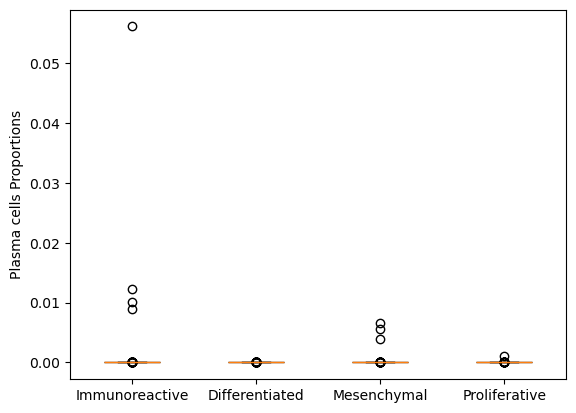

B cells


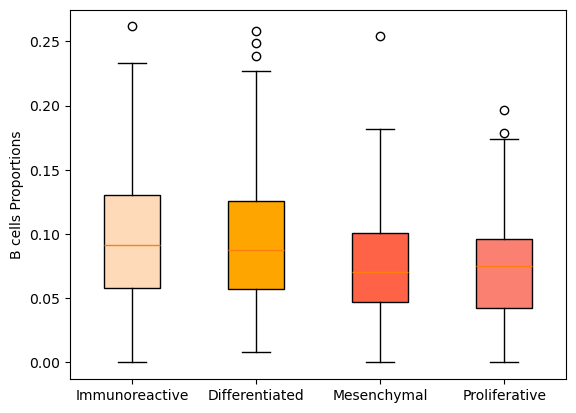

Endothelial cells


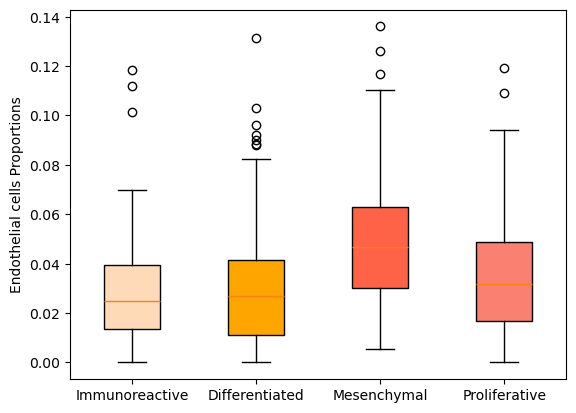

T cells


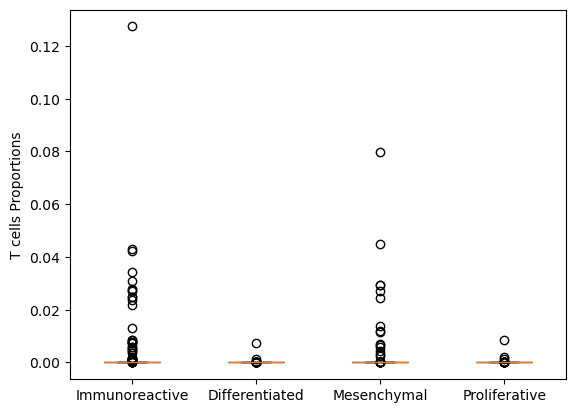

Monocytes


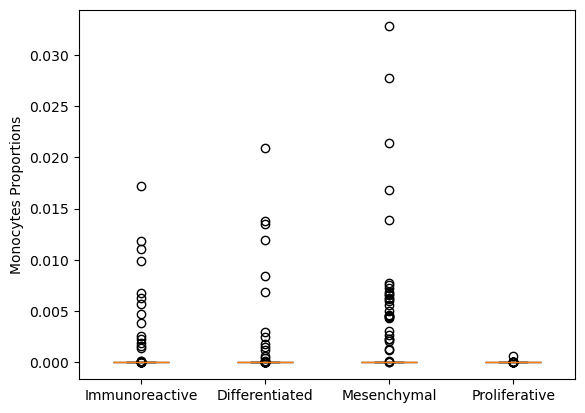

Fibroblasts


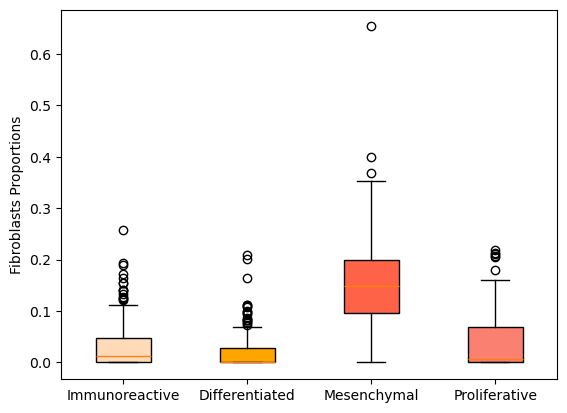

NK cells


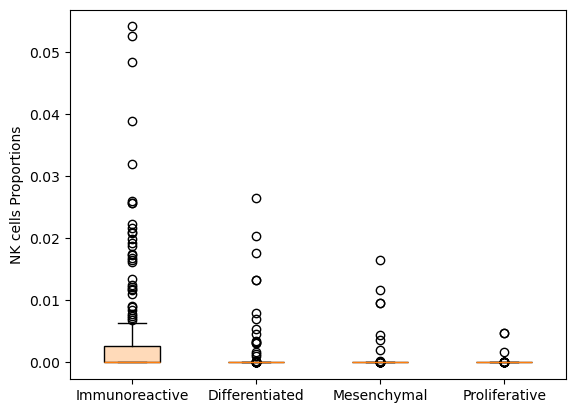

Epithelial cells


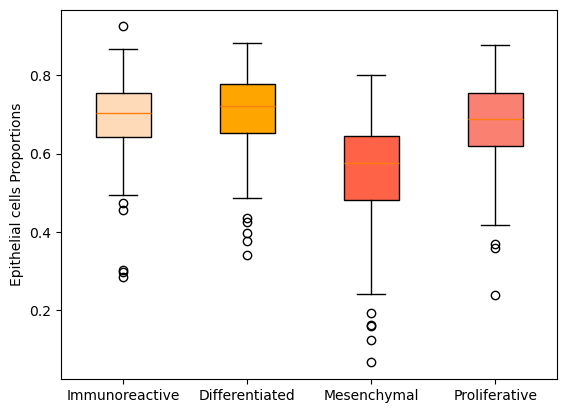

DC


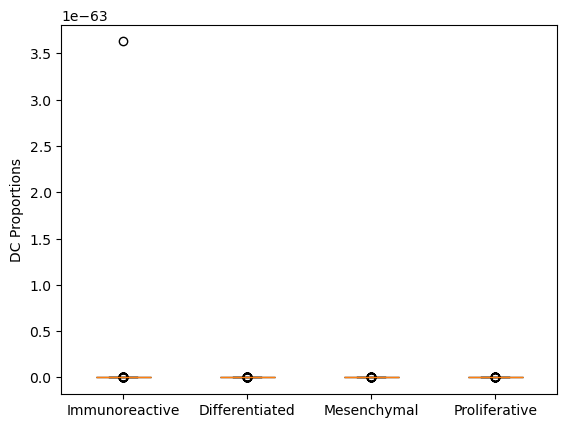

pDC


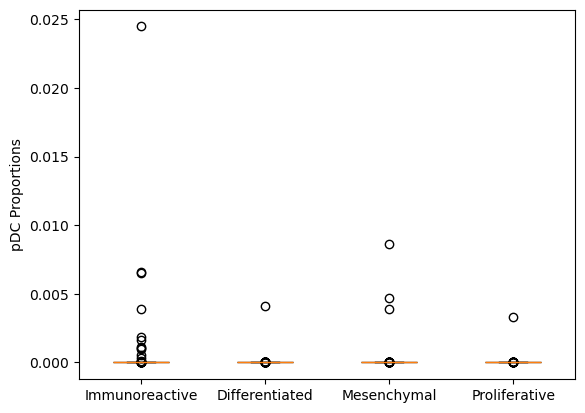

ILC


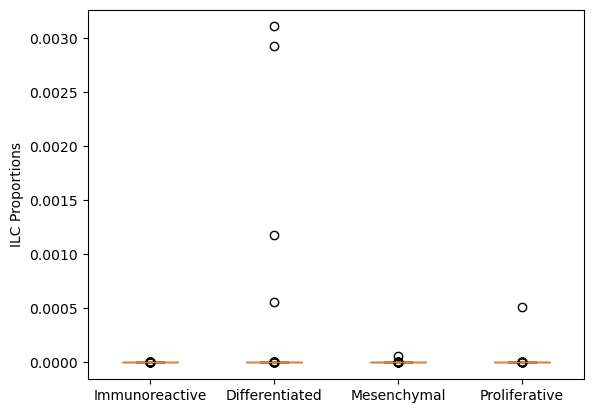

Macrophages


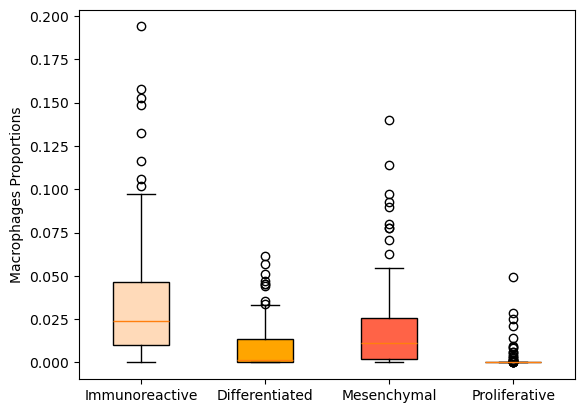

Mast cells


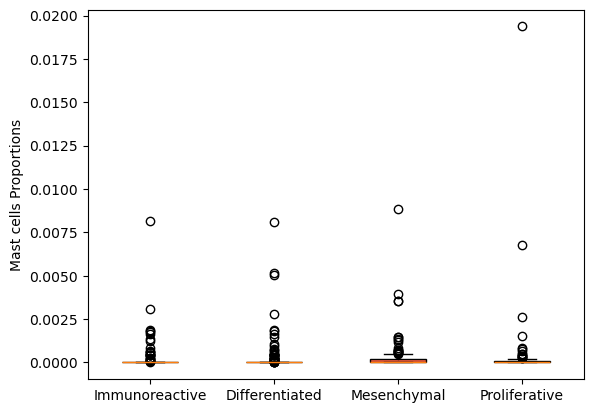

Erythroid


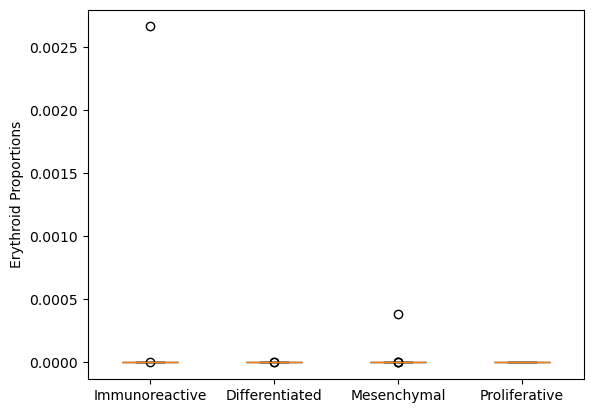

Adipocytes


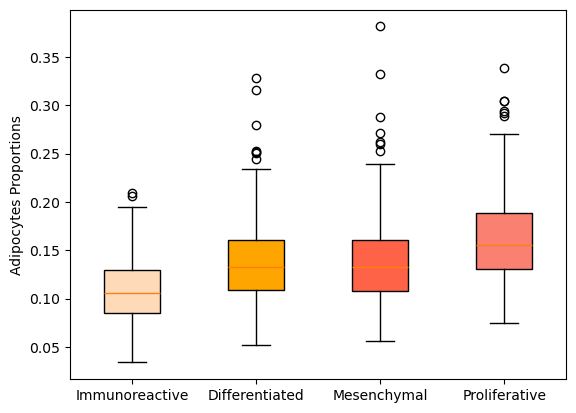

In [15]:
subtype_list = list(subtype_map.values())
labels = subtype_list
colors = ['peachpuff', 'orange', 'tomato', "salmon"]

for cell in cell_types:
    print(cell)

    om = df[df.Subtype==subtype_list[0]][cell]
    ov = df[df.Subtype==subtype_list[1]][cell]
    ovft = df[df.Subtype==subtype_list[2]][cell]
    ft = df[df.Subtype==subtype_list[3]][cell]

    values = [om, ov, ovft, ft]

    fig, ax = plt.subplots()
    ax.set_ylabel(f'{cell} Proportions')

    bplot = ax.boxplot(values,
                    patch_artist=True,  # fill with color
                    tick_labels=labels)  # will be used to label x-ticks

    # fill with colors
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    plt.show()

Now by group:

In [16]:
## Which cell types to use
immune_cells = ["B cells",
                        'Mast cells',
                    'T cells',
                    'Monocytes',
                    'Plasma cells',
                    "NK cells", 
                    "DC",
                    "pDC",  
                    "Macrophages", 
                    "ILC"]

stromal_cells = ["Fibroblasts",
                        'Endothelial cells']

df["Immune"] = df[immune_cells].sum(axis=1)
df["Stromal"] = df[stromal_cells].sum(axis=1)
df["Epithelial"] = df["Epithelial cells"]

df

,ID,Age,Event,Time_Yrs,Tissue,Stage,Race,BMI,AdjTx,Residual,...,ClusterK4_kmeans,ClusterK2_NMF,ClusterK3_NMF,ClusterK4_NMF,consensusOVsubtype,Dataset_y,Subtype,Immune,Stromal,Epithelial
0,40143,63,1,8.739220,NaN,3,1,23.218229,1.0,4.0,...,2,1,3,2,IMR_consensus,SchildkrautW,Immunoreactive,0.218528,5.741863e-02,0.610632
1,41377,54,1,1.180014,NaN,3,1,17.428942,NaN,3.0,...,4,2,1,3,DIF_consensus,SchildkrautW,Differentiated,0.096819,3.138082e-02,0.702189
2,41387,55,1,11.983573,NaN,3,2,45.470350,1.0,2.0,...,2,2,1,1,IMR_consensus,SchildkrautB,Immunoreactive,0.086715,1.228492e-01,0.725604
3,41391,60,1,4.993840,NaN,3,1,31.340800,NaN,3.0,...,4,1,2,3,DIF_consensus,SchildkrautW,Differentiated,0.107769,1.118747e-01,0.660983
4,41435,59,1,4.057495,NaN,3,1,23.922658,NaN,NaN,...,2,2,3,2,IMR_consensus,SchildkrautW,Immunoreactive,0.087462,6.225249e-02,0.739953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,310266,40,0,9.702186,Fallopian Tube,3,2,28.349557,NaN,NaN,...,1,1,1,4,MES_consensus,SchildkrautB,Mesenchymal,0.049467,7.507748e-02,0.777904
584,320012,66,0,11.767760,NaN,3,2,37.677475,1.0,4.0,...,2,2,3,3,DIF_consensus,SchildkrautB,Differentiated,0.093217,9.157968e-51,0.771372
585,320025,60,1,6.827869,Other,3,2,38.740537,1.0,3.0,...,1,2,3,3,PRO_consensus,SchildkrautB,Proliferative,0.134981,2.364402e-02,0.660166
586,320043,57,1,1.553425,NaN,3,2,19.854802,1.0,4.0,...,2,2,3,3,IMR_consensus,SchildkrautB,Immunoreactive,0.201393,2.243354e-02,0.570443


Fractions are bounded (0-1), markedly right-skewed, and group sizes are often small/unequal. Heteroscedastic, non-normal data across >2 groups make the non-parametric KW test safer than one-way ANOVA without needing normality / equal-variance assumptions.

Subtype × Adipocyte / Immune / Stromal – logit-transform ANOVA + Bonferroni

In [17]:
# ─────────────────────────────────────────────────────────────────────────────
# 1.  Prep – keep rows with non-missing Subtype, add logit-transformed columns
# ─────────────────────────────────────────────────────────────────────────────
df_sub = df.dropna(subset=["Subtype"]).copy()
print("Subtype counts:\n", df_sub["Subtype"].value_counts())

for frac in fractions:
    p            = df_sub[frac]
    df_sub[f"logit_{frac}"] = np.log(p / (1-p))

# ─────────────────────────────────────────────────────────────────────────────
# 2.  Omnibus ANOVA on logit-scaled fractions
# ─────────────────────────────────────────────────────────────────────────────
# define your four groups explicitly
levels = ["Immunoreactive","Differentiated","Mesenchymal","Proliferative"]

rows = []
for frac in fractions:
    col = f"logit_{frac}"   # run ANOVA on the logit scale
    # build one array per subtype
    groups = [
        df_sub.loc[df_sub["Subtype"] == lvl, col].dropna()
        for lvl in levels
    ]
    # sanity check: all groups must have >= 2 points
    lengths = [len(g) for g in groups]
    print(f"{frac} group sizes: {dict(zip(levels,lengths))}")
    
    f_stat, p_val = f_oneway(*groups)
    print(f"{frac}: F = {f_stat:.3f}, p = {p_val:.3e}\n")
    rows.append({"Fraction": frac, "p_raw": p_val})

# then Bonferroni‐correct just as before
res = pd.DataFrame(rows)
res["p_bonf"] = multipletests(res.p_raw, method="bonferroni")[1]
res = res.sort_values("p_bonf")

print("\n=== Omnibus ANOVA on logit fractions (Bonferroni sorted) ===")
display(res)

# # ─────────────────────────────────────────────────────────────────────────────
# # 3.  Tukey pair-wise contrasts for Bonferroni-significant fractions
# # ─────────────────────────────────────────────────────────────────────────────
# for frac in res.loc[res.p_bonf < 0.05, "Fraction"]:
#     print(f"\n--- Tukey HSD for {frac} (Bonferroni-sig) ---")
#     tuk = pairwise_tukeyhsd(endog=df_sub[f"logit_{frac}"],
#                             groups=df_sub["Subtype"],
#                             alpha=0.05)
#     print(tuk.summary())

Subtype counts:
 Subtype
Differentiated    180
Immunoreactive    173
Mesenchymal       132
Proliferative     103
Name: count, dtype: int64
Adipocytes group sizes: {'Immunoreactive': 173, 'Differentiated': 180, 'Mesenchymal': 132, 'Proliferative': 103}
Adipocytes: F = 40.797, p = 6.028e-24

Immune group sizes: {'Immunoreactive': 173, 'Differentiated': 180, 'Mesenchymal': 132, 'Proliferative': 103}
Immune: F = 36.215, p = 1.782e-21

Stromal group sizes: {'Immunoreactive': 173, 'Differentiated': 180, 'Mesenchymal': 132, 'Proliferative': 103}
Stromal: F = 6.563, p = 2.281e-04

Epithelial group sizes: {'Immunoreactive': 173, 'Differentiated': 180, 'Mesenchymal': 132, 'Proliferative': 103}
Epithelial: F = 53.017, p = 2.563e-30


=== Omnibus ANOVA on logit fractions (Bonferroni sorted) ===


,Fraction,p_raw,p_bonf
3,Epithelial,2.562877e-30,1.025151e-29
0,Adipocytes,6.027526e-24,2.411010e-23
1,Immune,1.781505e-21,7.126021e-21
2,Stromal,2.280681e-04,9.122724e-04


In [ ]:
# ---------- 1.  Tukey–HSD results into dict ---------------------------------
# fractions      = ["Adipocytes", "Immune", "Stromal"]
tukey_dict = {}
for frac in fractions:
    res_  = pairwise_tukeyhsd(endog=df_sub[f"logit_{frac}"],
                             groups=df_sub["Subtype"], alpha=0.05)
    tuk  = pd.DataFrame(res_.summary().data[1:], columns=res_.summary().data[0])
    tukey_dict[frac] = tuk

# ---------- 2.  helper -------------------------------------------------------
" if p < .001 else "**" if p < .01 else "*" if p < .05 else ""

# ---------- 3.  long data for raw proportions (for boxes & y-max) ------------
long_all = (df_sub[["Subtype"] + fractions]
            .melt(id_vars="Subtype", var_name="Fraction", value_name="Prop"))
long_all["Subtype"] = pd.Categorical(long_all["Subtype"], categories=subtype_order, ordered=True)

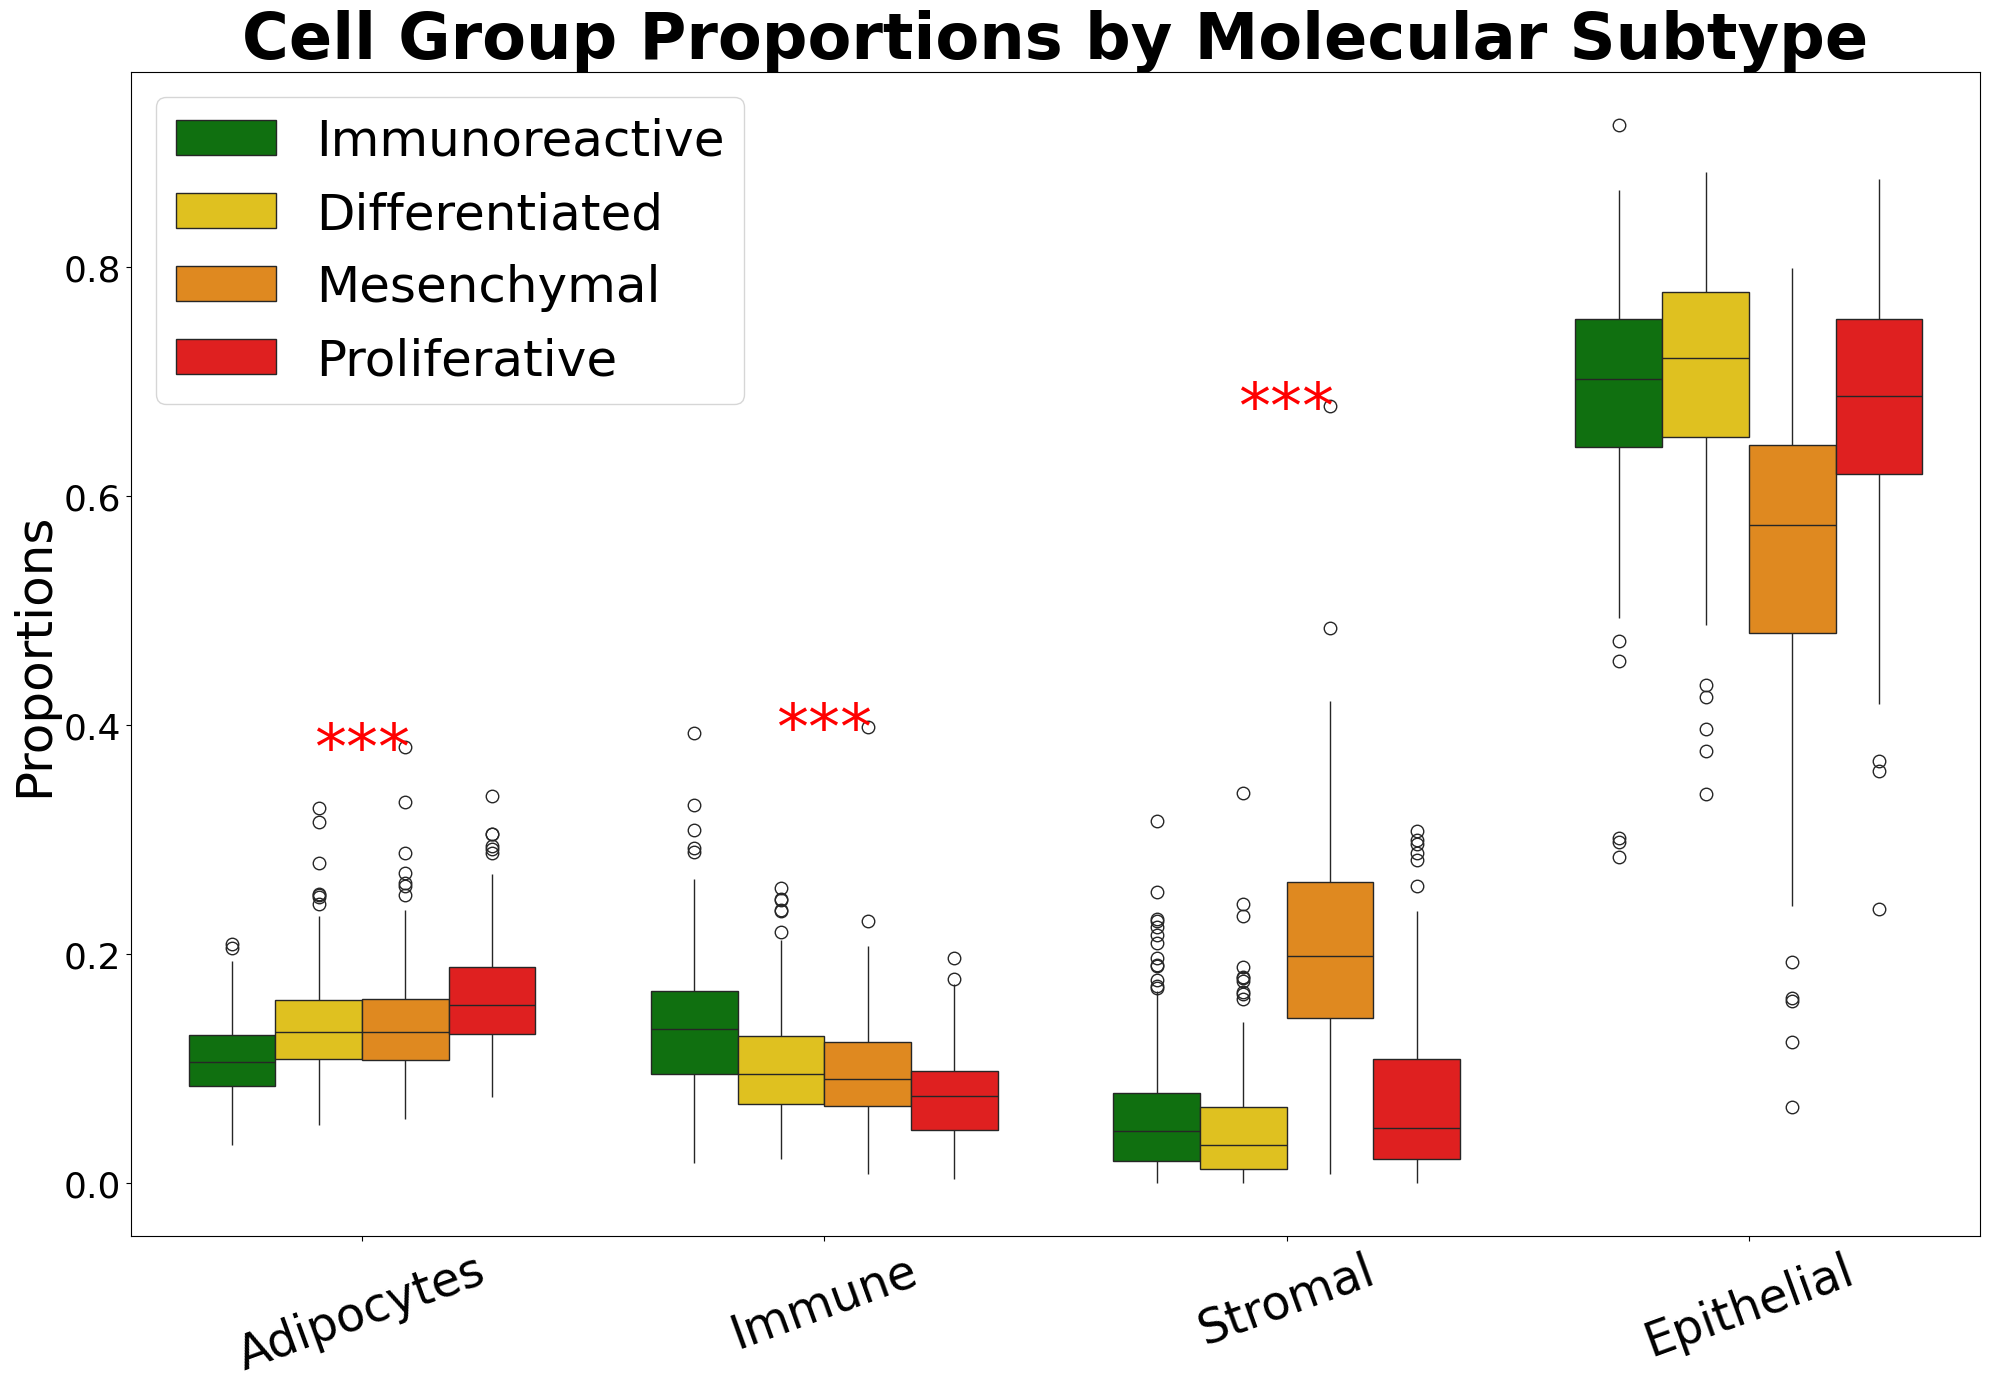

In [ ]:
# colour palette for the four subtypes
custom_colors = ["green", "#FFD700", "darkorange", "red"] 
palette = dict(zip(subtype_order, custom_colors))

# --- plot -------------------------------------------------------------------
plt.figure(figsize=(20,14))
ax = sns.boxplot(data=long_all, x="Fraction", y="Prop",
                 hue="Subtype", palette=palette, width=0.75,
                 showcaps=False, fliersize=9)

# significance stars from the omnibus table
for i, frac in enumerate(["Adipocytes","Immune","Stromal"]):
    star  = hp.p_to_star(res.loc[res.Fraction == frac, "p_bonf"].values[0])
    if star:
        y_max = long_all.loc[long_all.Fraction == frac, "Prop"].max() - 0.05
        ax.text(i, y_max + 0.02, star, ha="center",
                va="bottom", color="red", fontsize=46)

plt.ylabel("Proportions", fontsize=36)
plt.xlabel("", fontsize=36)
plt.title("Cell Group Proportions by Molecular Subtype",  fontsize=46, fontweight="bold")
plt.legend(title="",fontsize=24, loc='best')
plt.xticks(fontsize=34, rotation=20)
plt.yticks(fontsize=26)

# clean legend (optional: custom order)
handles, labels = ax.get_legend_handles_labels()
order = [labels.index(s) for s in subtype_order if s in labels]
ax.legend([handles[i] for i in order], subtype_order, fontsize=36,
          loc="best")

plt.tight_layout()
plt.show()

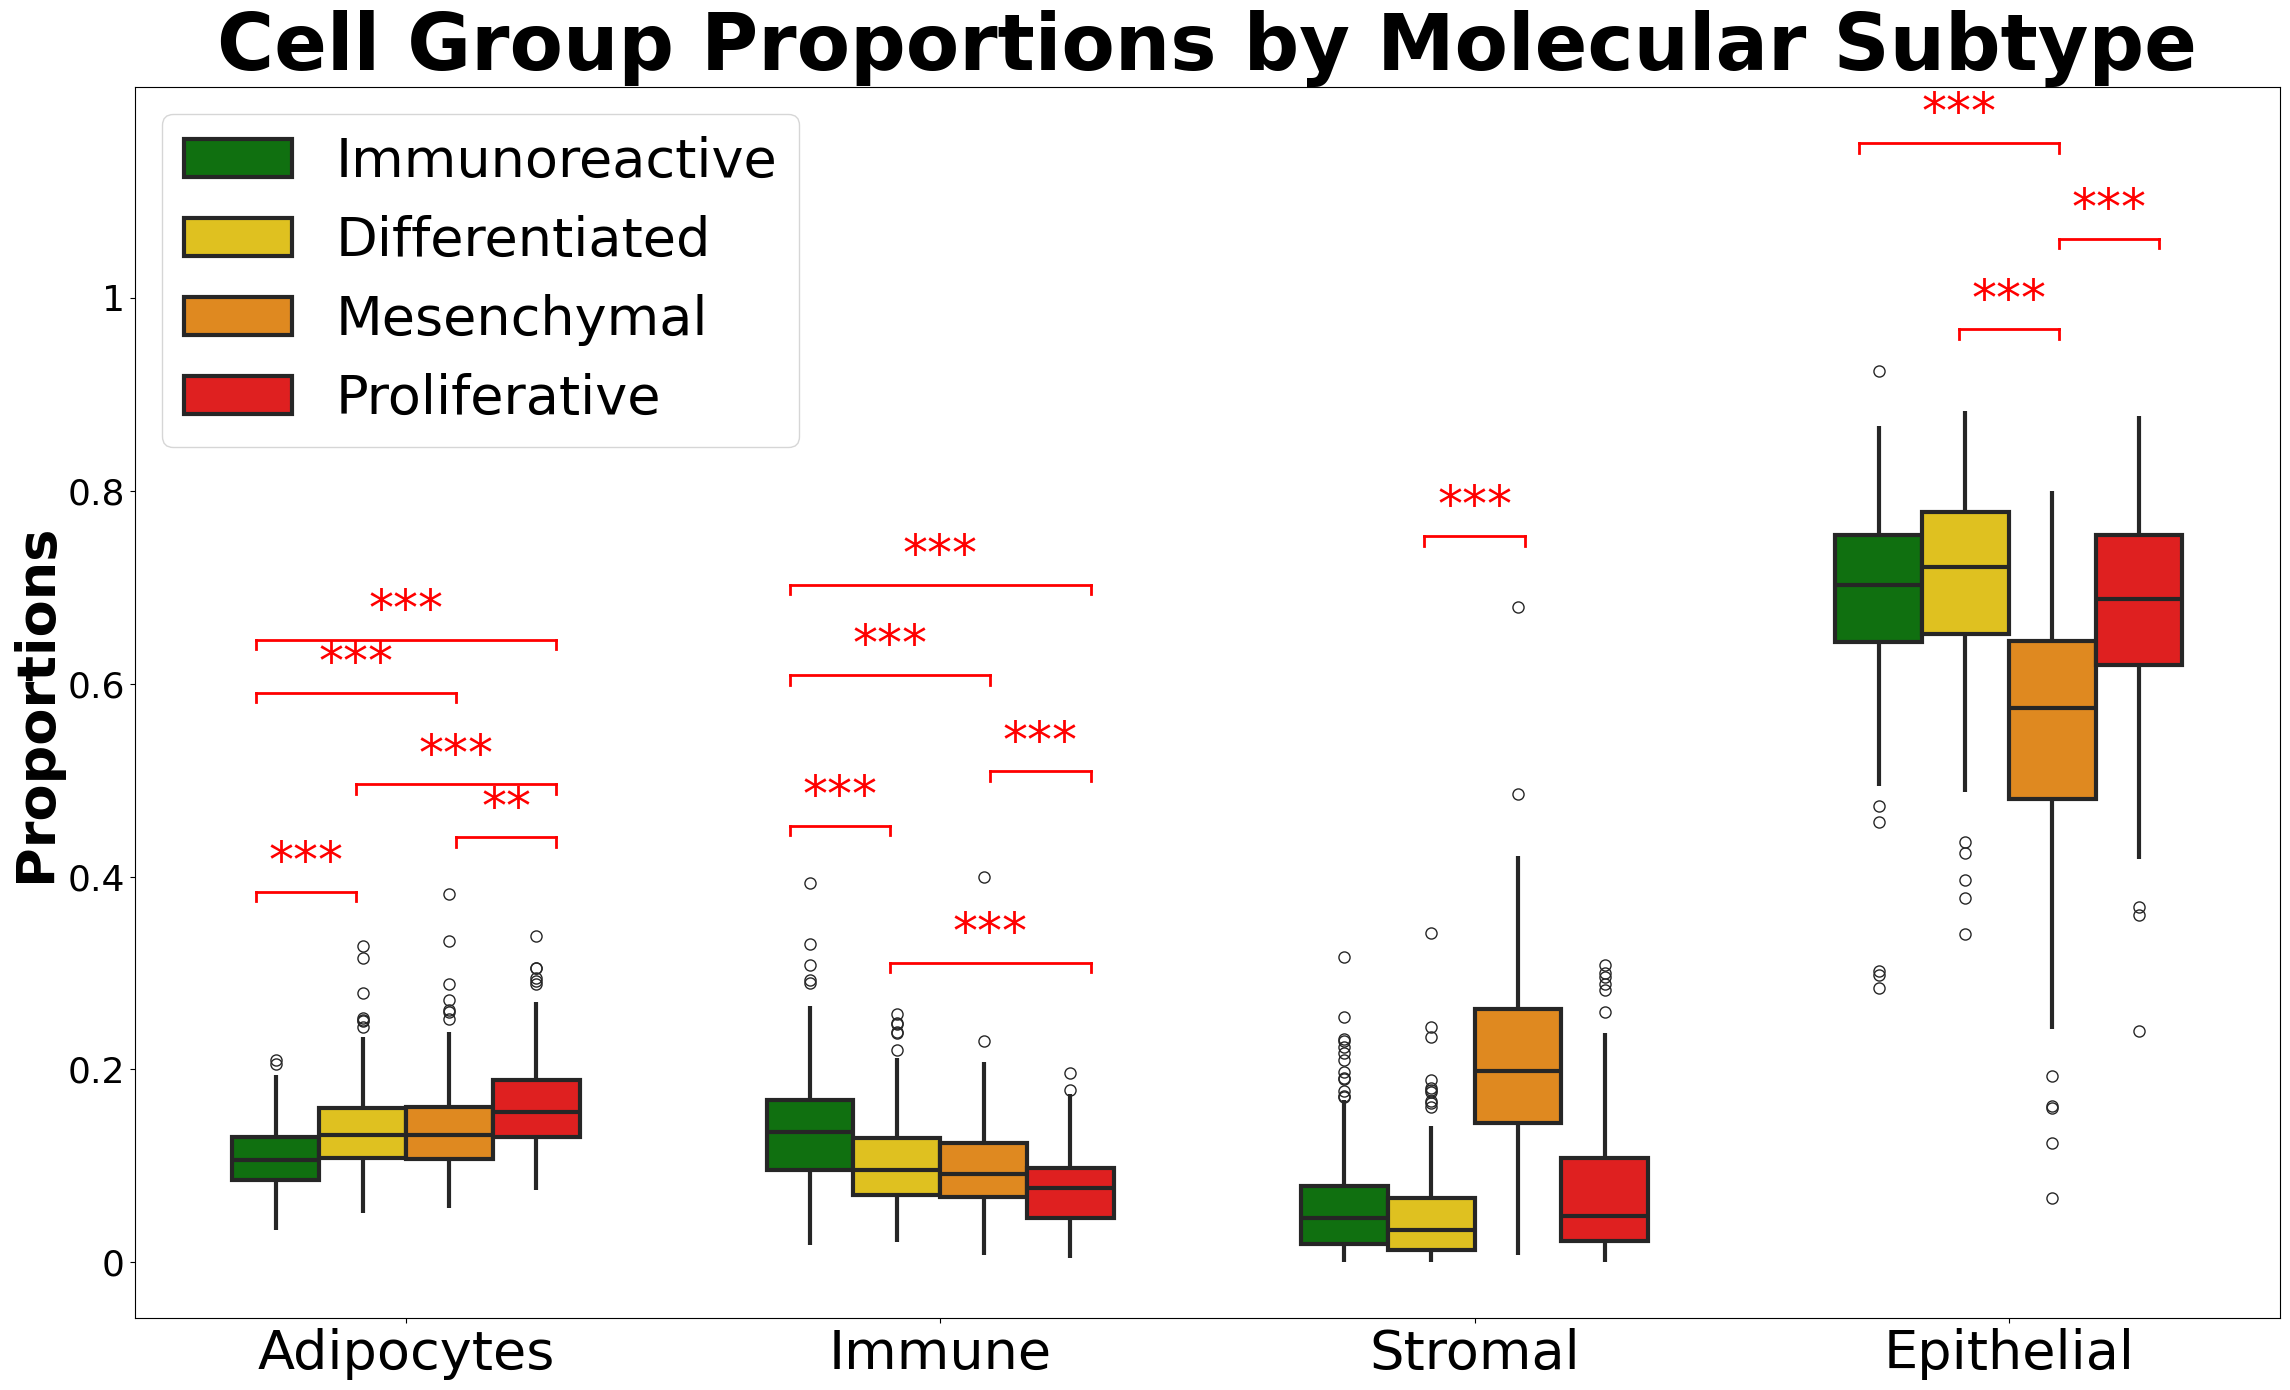

In [ ]:
# ---------- 4.  plot ---------------------------------------------------------
custom_colors = ["green", "gold", "darkorange", "red"] 
palette = dict(zip(subtype_order, custom_colors))

plt.figure(figsize=(23,14))
ax = sns.boxplot(data=long_all, x="Fraction", y="Prop",
                 hue="Subtype", hue_order=subtype_order,   # ← enforce order
                 palette=palette, width=.65, linewidth=3,
                 showcaps=False, fliersize=8)

# ---------- 5.  add brackets -------------------------------------------------
box_w     = .75
inner_w   = box_w / len(subtype_order)

for f_i, frac in enumerate(fractions):
    base_x = f_i - box_w/2 + inner_w/2
    tuk    = tukey_dict[frac]

    # keep only sig. pairs, sort by |idx2−idx1| to draw short first
    sig    = tuk[tuk["reject"] == True].copy()
    sig["span"] = sig.apply(
        lambda r: abs(subtype_order.index(r["group2"]) -
                      subtype_order.index(r["group1"])), axis=1)
    sig = sig.sort_values("span")                       # narrow → wide

    # Store bracket positions for overlap checking
    used_levels = []

    for _, row in sig.iterrows():
        g1, g2   = row["group1"], row["group2"]
        p_star   = hp.p_to_star(float(row["p-adj"]))
        if not p_star:
            continue

        idx1, idx2 = subtype_order.index(g1), subtype_order.index(g2)
        x1         = base_x + idx1*inner_w
        x2         = base_x + idx2*inner_w

        y_max = long_all[(long_all.Fraction == frac) &
                        (long_all.Subtype.isin([g1, g2]))]["Prop"].max()
        y_base = y_max * 1.05 + 0.04

        # Find lowest level that doesn't overlap with existing brackets
        vstep = 0.05     # vertical spacing between bracket levels
        for level in itertools.count():
            y_brk = y_base + vstep * level
            overlaps = any(abs(y_brk - y) < 0.05 for y in used_levels)
            if not overlaps:
                used_levels.append(y_brk)
                break

        # Draw bracket
        ax.plot([x1, x2], [y_brk, y_brk], color="red", lw=2)
        ax.plot([x1, x1], [y_brk, y_brk-0.01], color="red", lw=2)
        ax.plot([x2, x2], [y_brk, y_brk-0.01], color="red", lw=2)
        ax.text((x1+x2)/2, y_brk + 0.005, p_star,
                ha="center", va="bottom", color="red", fontsize=36)

# ---------- 6.  cosmetics ----------------------------------------------------
ax.set_ylabel("Proportion", fontsize=26)
ax.set_xlabel("")
ax.set_title("Adipocyte, Immune and Stromal fractions by molecular subtype\n"
             "(Tukey HSD: *, **, ***)", fontsize=28, weight="bold")
ax.tick_params(axis='both', labelsize=20)
ax.legend(title="", fontsize=45, loc="best")
plt.tight_layout()
plt.ylabel("Proportions", fontsize=39, fontweight="bold")
plt.xlabel("", fontsize=39)
plt.title("Cell Group Proportions by Molecular Subtype",  fontsize=56, fontweight="bold")
plt.legend(title="",fontsize=39, loc='upper left')
plt.xticks(fontsize=39)
plt.yticks(ticks=[0,0.2, 0.4, 0.6, 0.8, 1], labels=[0,0.2, 0.4, 0.6, 0.8, 1], fontsize=26)
plt.tight_layout()
plt.show()

In [ ]:
assert (df_sub[["Adipocytes","Immune","Stromal"]] > 0).all().all()
assert (df_sub[["Adipocytes","Immune","Stromal"]] < 1).all().all()

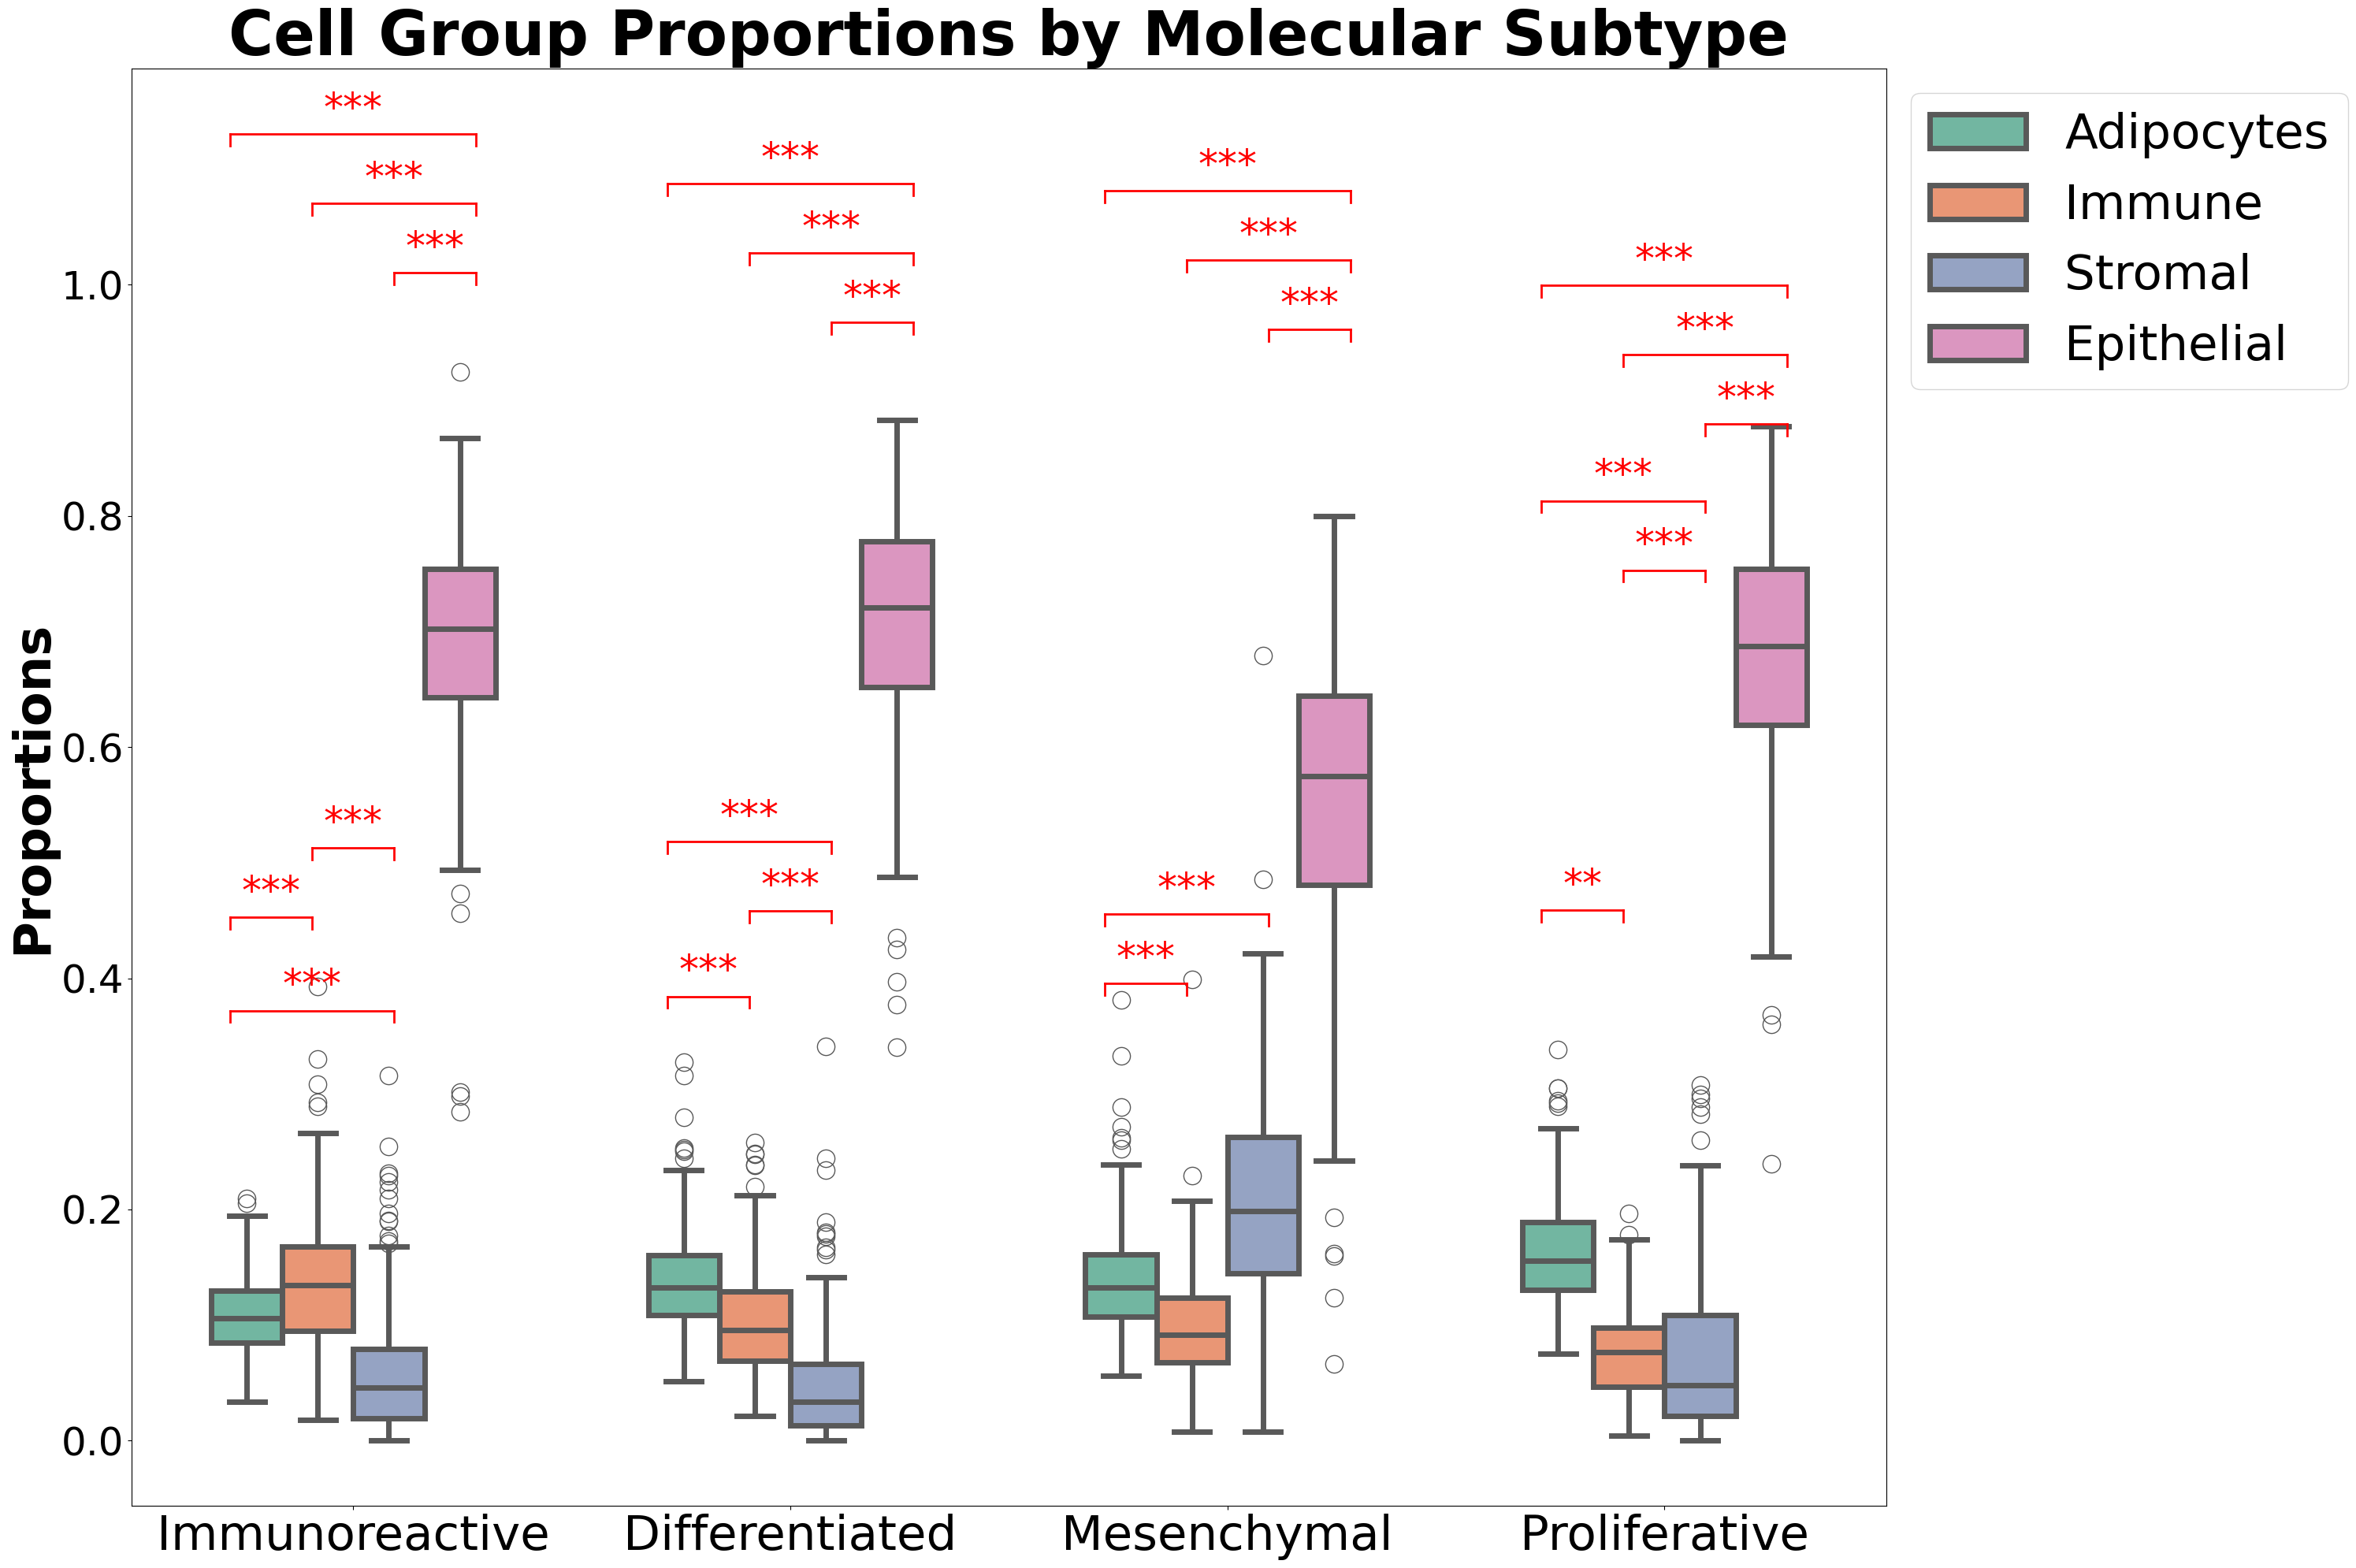

In [ ]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
subtypes = df_sub["Subtype"].unique()

# Tukey tests for each subtype across cell fractions
tukey_dict = {}
for subtype in subtypes:
    data_sub = df_sub[df_sub["Subtype"] == subtype]
    data_long = data_sub.melt(value_vars=fractions, var_name="Fraction", value_name="Prop")
    res = pairwise_tukeyhsd(endog=data_long["Prop"], groups=data_long["Fraction"], alpha=0.05)
    tuk = pd.DataFrame(res.summary().data[1:], columns=res.summary().data[0])
    tukey_dict[subtype] = tuk

# Long data
long_all = df_sub.melt(id_vars="Subtype", value_vars=fractions, var_name="Fraction", value_name="Prop")

# Plot
plt.figure(figsize=(30,20))
ax = sns.boxplot(data=long_all, x="Subtype", y="Prop", hue="Fraction", palette="Set2",  width=.65,
        showcaps=True, fliersize=16, linewidth=5, order=subtype_order)

# Adding significance brackets
box_w = .75
inner_w = box_w / len(fractions)

for s_i, subtype in enumerate(subtypes):
    base_x = s_i - box_w / 2 + inner_w / 2
    tuk = tukey_dict[subtype]
    sig = tuk[tuk["reject"]].copy()
    sig["span"] = sig.apply(lambda r: abs(fractions.index(r["group2"]) - fractions.index(r["group1"])), axis=1)
    sig = sig.sort_values("span")

    used_levels = []
    for _, row in sig.iterrows():
        g1, g2 = row["group1"], row["group2"]
        p_star = hp.p_to_star(float(row["p-adj"]))
        if not p_star:
            continue

        idx1, idx2 = fractions.index(g1), fractions.index(g2)
        x1 = base_x + idx1 * inner_w
        x2 = base_x + idx2 * inner_w

        y_max = long_all[(long_all.Subtype == subtype) &
                         (long_all.Fraction.isin([g1, g2]))]["Prop"].max()
        y_base = y_max * 1.05 + 0.04

        for level in itertools.count():
            y_brk = y_base + 0.06 * level
            overlaps = any(abs(y_brk - y) < 0.05 for y in used_levels)
            if not overlaps:
                used_levels.append(y_brk)
                break

        ax.plot([x1, x2], [y_brk, y_brk], color="red", lw=2)
        ax.plot([x1, x1], [y_brk, y_brk - 0.01], color="red", lw=2)
        ax.plot([x2, x2], [y_brk, y_brk - 0.01], color="red", lw=2)
        ax.text((x1 + x2) / 2, y_brk + 0.005, p_star, ha="center", va="bottom", color="red", fontsize=36)

# Cosmetics
plt.ylabel("Proportions", fontsize=46, fontweight="bold")
plt.xlabel("", fontsize=46, fontweight="bold")
ax.set_title("Cell Group Proportions by Molecular Subtype",  fontsize=56, fontweight="bold")
ax.tick_params(axis='both', labelsize=20)
plt.xlabel("", fontsize=46, fontweight="bold")
plt.legend(title="",fontsize=44,bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(fontsize=44)
plt.yticks(fontsize=36)
plt.tight_layout()
plt.show()